# Notebook Imports

In [1]:
!pip install prince

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.6/415.6 kB 8.5 MB/s eta 0:00:00


In [2]:
import os
import re
import pandas as pd
import numpy as np
from datetime import date
import seaborn as sns
from scipy import stats
from umap import UMAP

import matplotlib.pyplot as plt
import warnings
from prince import MCA, CA
from sklearn.impute import SimpleImputer
import calendar
from yellowbrick.cluster import SilhouetteVisualizer

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.manifold import TSNE

warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argume

# Constants

In [3]:
FILE = '/kaggle/input/data-science-for-good/Dept_11-00091/11-00091_Field-Interviews_2011-2015.csv'

# Step 1: Data Exploration and Preprocessing

### Load data

In [4]:
data = pd.read_csv(FILE)
df = pd.DataFrame(data)

df.drop([0], axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

,INCIDENT_UNIQUE_IDENTIFIER,INCIDENT_UNIQUE_IDENTIFIER.1,SUBJECT_GENDER,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,LOCATION_DISTRICT,LOCATION_DISTRICT.1,INCIDENT_DATE,INCIDENT_TIME,SUBJECT_DETAILS,SUBJECT_RACE,...,VEHICLE_DETAILS.1,OFFICER_SUPERVISOR,OFFICER_ID,OFFICER_ASSIGNMENT,OFFICER_ASSIGNMENT.1,OFFICER_ETHNICITY,OFFICER_RACE,OFFICER_AGE,LOCATION_STREET_NUMBER,LOCATION_CITY
0,938283,621880,MALE,NORMANDY ST at SUPPLE RD,B2,3,12/10/13 0:00,12/10/13 0:00,YES,B(Black),...,MA,10132,98656,9999,OTHER,NaN,B(Black),59,3274,NO DATA ENTERED
1,881897,565177,MALE,75 BOYLSTON ST,A1,1,5/24/12 0:00,5/24/12 0:00,NO,W(White),...,NO DATA ENTERED,8949,9765,1,A1,NaN,W(White),26,543,OTHER
2,882060,565340,MALE,5 TOPLIFF ST,C11,5,6/4/12 0:00,6/4/12 0:00,YES,B(Black),...,NO DATA ENTERED,11312,83575,16,YVSF,NaN,B(Black),18,4493,NO DATA ENTERED
3,971623,653895,MALE,170 MORTON ST,B2,3,6/21/14 0:00,6/21/14 0:00,YES,B(Black),...,NO DATA ENTERED,9375,76146,25,BIKE,NaN,B(Black),24,3094,Dorchester
4,882761,566043,MALE,0 ST ALPHONSUS ST,B2,3,12/2/10 0:00,12/2/10 0:00,YES,B(Black),...,MA,NaN,107106,3,B2,NaN,B(Black),70,4241,Dorchester


In [5]:
print(f"\nThe shape of the data: {df.shape}\n")
print(f"The types of the data: \n{df.dtypes}\n")
print(f"The empty row in the data: \n{df.isnull().sum()}")


The shape of the data: (152230, 34)

The types of the data: 
INCIDENT_UNIQUE_IDENTIFIER                      object
INCIDENT_UNIQUE_IDENTIFIER.1                    object
SUBJECT_GENDER                                  object
LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION    object
LOCATION_DISTRICT                               object
LOCATION_DISTRICT.1                             object
INCIDENT_DATE                                   object
INCIDENT_TIME                                   object
SUBJECT_DETAILS                                 object
SUBJECT_RACE                                    object
SUBJECT_DETAILS.1                               object
SUBJECT_DETAILS.2                               object
UNKNOWN_FIELD_TYPE                              object
UNKNOWN_FIELD_TYPE.1                            object
SEARCH_CONDUCTED                                object
SEARCH_REASON                                   object
INCIDENT_REASON                                 object
INC

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152230 entries, 0 to 152229
Data columns (total 34 columns):
 #   Column                                        Non-Null Count   Dtype 
---  ------                                        --------------   ----- 
 0   INCIDENT_UNIQUE_IDENTIFIER                    152230 non-null  object
 1   INCIDENT_UNIQUE_IDENTIFIER.1                  152230 non-null  object
 2   SUBJECT_GENDER                                152230 non-null  object
 3   LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION  152228 non-null  object
 4   LOCATION_DISTRICT                             152230 non-null  object
 5   LOCATION_DISTRICT.1                           152230 non-null  object
 6   INCIDENT_DATE                                 152230 non-null  object
 7   INCIDENT_TIME                                 152230 non-null  object
 8   SUBJECT_DETAILS                               131331 non-null  object
 9   SUBJECT_RACE                                  152230 non-nu

### Data Cleaning

In [7]:
# converting 'NO DATA ENTERED', 'UNKNOWN' values in columns to NaN values
for feature in df.columns:
    df[feature].replace(to_replace=["NO DATA ENTERED", 'UNKNOWN', '0', 0], value=np.nan, inplace=True)

In [8]:
print(f"The empty row in the data: \n{df.isnull().sum()}")

The empty row in the data: 
INCIDENT_UNIQUE_IDENTIFIER                           0
INCIDENT_UNIQUE_IDENTIFIER.1                         0
SUBJECT_GENDER                                     237
LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION         2
LOCATION_DISTRICT                                    0
LOCATION_DISTRICT.1                                  0
INCIDENT_DATE                                        0
INCIDENT_TIME                                        0
SUBJECT_DETAILS                                  22538
SUBJECT_RACE                                      6647
SUBJECT_DETAILS.1                                13621
SUBJECT_DETAILS.2                                22886
UNKNOWN_FIELD_TYPE                                   0
UNKNOWN_FIELD_TYPE.1                                 0
SEARCH_CONDUCTED                                131590
SEARCH_REASON                                   116686
INCIDENT_REASON                                  46908
INCIDENT_REASON.1                    

In [9]:
# dropping columns where the NaN values were more than 30000
for feature in df.columns:
    if df[feature].isnull().sum() > 30000:
        df.drop([feature], axis=1, inplace=True)

In [10]:
df.head()

,INCIDENT_UNIQUE_IDENTIFIER,INCIDENT_UNIQUE_IDENTIFIER.1,SUBJECT_GENDER,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,LOCATION_DISTRICT,LOCATION_DISTRICT.1,INCIDENT_DATE,INCIDENT_TIME,SUBJECT_DETAILS,SUBJECT_RACE,...,UNKNOWN_FIELD_TYPE.1,INCIDENT_REASON.1,DISPOSITION,OFFICER_SUPERVISOR,OFFICER_ID,OFFICER_ASSIGNMENT,OFFICER_ASSIGNMENT.1,OFFICER_RACE,OFFICER_AGE,LOCATION_STREET_NUMBER
0,938283,621880,MALE,NORMANDY ST at SUPPLE RD,B2,3,12/10/13 0:00,12/10/13 0:00,YES,B(Black),...,NO,"DRUGS, INVESTIGATION",SFO,10132,98656,9999,OTHER,B(Black),59,3274
1,881897,565177,MALE,75 BOYLSTON ST,A1,1,5/24/12 0:00,5/24/12 0:00,NO,W(White),...,NO,"DRUGS, POSSESSION",F,8949,9765,1,A1,W(White),26,543
2,882060,565340,MALE,5 TOPLIFF ST,C11,5,6/4/12 0:00,6/4/12 0:00,YES,B(Black),...,NO,"INVESTIGATE, PERSON",F,11312,83575,16,YVSF,B(Black),18,4493
3,971623,653895,MALE,170 MORTON ST,B2,3,6/21/14 0:00,6/21/14 0:00,YES,B(Black),...,NO,ABDW,S,9375,76146,25,BIKE,B(Black),24,3094
4,882761,566043,MALE,0 ST ALPHONSUS ST,B2,3,12/2/10 0:00,12/2/10 0:00,YES,B(Black),...,NO,VAL,F,NaN,107106,3,B2,B(Black),70,4241


In [11]:
# Number of unique values in the dataset columns
for feature in df.columns:
    print(f'Number of unique values in {feature} column:', len(df[feature].unique()))

Number of unique values in INCIDENT_UNIQUE_IDENTIFIER column: 152230
Number of unique values in INCIDENT_UNIQUE_IDENTIFIER.1 column: 152230
Number of unique values in SUBJECT_GENDER column: 3
Number of unique values in LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION column: 38361
Number of unique values in LOCATION_DISTRICT column: 24
Number of unique values in LOCATION_DISTRICT.1 column: 43
Number of unique values in INCIDENT_DATE column: 2140
Number of unique values in INCIDENT_TIME column: 2140
Number of unique values in SUBJECT_DETAILS column: 3
Number of unique values in SUBJECT_RACE column: 7
Number of unique values in SUBJECT_DETAILS.1 column: 102127
Number of unique values in SUBJECT_DETAILS.2 column: 10
Number of unique values in UNKNOWN_FIELD_TYPE column: 26
Number of unique values in UNKNOWN_FIELD_TYPE.1 column: 2
Number of unique values in INCIDENT_REASON.1 column: 222
Number of unique values in DISPOSITION column: 8
Number of unique values in OFFICER_SUPERVISOR column: 337
Nu

In [12]:
print(f"The empty row in the data: \n{df.isnull().sum()}")

The empty row in the data: 
INCIDENT_UNIQUE_IDENTIFIER                          0
INCIDENT_UNIQUE_IDENTIFIER.1                        0
SUBJECT_GENDER                                    237
LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION        2
LOCATION_DISTRICT                                   0
LOCATION_DISTRICT.1                                 0
INCIDENT_DATE                                       0
INCIDENT_TIME                                       0
SUBJECT_DETAILS                                 22538
SUBJECT_RACE                                     6647
SUBJECT_DETAILS.1                               13621
SUBJECT_DETAILS.2                               22886
UNKNOWN_FIELD_TYPE                                  0
UNKNOWN_FIELD_TYPE.1                                0
INCIDENT_REASON.1                                   0
DISPOSITION                                      8914
OFFICER_SUPERVISOR                              16454
OFFICER_ID                                          0


In [13]:
df.shape

(152230, 23)

In [14]:
df.drop(['INCIDENT_UNIQUE_IDENTIFIER', 'INCIDENT_UNIQUE_IDENTIFIER.1', 'OFFICER_ID', 'INCIDENT_TIME', 'OFFICER_SUPERVISOR', 
         'OFFICER_ASSIGNMENT', 'LOCATION_STREET_NUMBER', 'SUBJECT_DETAILS.1', 'OFFICER_RACE'], axis=1, inplace=True)

In [15]:
df.shape

(152230, 14)

In [16]:
df.head()

,SUBJECT_GENDER,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,LOCATION_DISTRICT,LOCATION_DISTRICT.1,INCIDENT_DATE,SUBJECT_DETAILS,SUBJECT_RACE,SUBJECT_DETAILS.2,UNKNOWN_FIELD_TYPE,UNKNOWN_FIELD_TYPE.1,INCIDENT_REASON.1,DISPOSITION,OFFICER_ASSIGNMENT.1,OFFICER_AGE
0,MALE,NORMANDY ST at SUPPLE RD,B2,3,12/10/13 0:00,YES,B(Black),Med,IOFS,NO,"DRUGS, INVESTIGATION",SFO,OTHER,59
1,MALE,75 BOYLSTON ST,A1,1,5/24/12 0:00,NO,W(White),Med,IO,NO,"DRUGS, POSSESSION",F,A1,26
2,MALE,5 TOPLIFF ST,C11,5,6/4/12 0:00,YES,B(Black),Dark,IOF,NO,"INVESTIGATE, PERSON",F,YVSF,18
3,MALE,170 MORTON ST,B2,3,6/21/14 0:00,YES,B(Black),Med,IOFS,NO,ABDW,S,BIKE,24
4,MALE,0 ST ALPHONSUS ST,B2,3,12/2/10 0:00,YES,B(Black),Light,IO,NO,VAL,F,B2,70


In [17]:
df.duplicated().value_counts()

False    148347
True       3883
Name: count, dtype: int64

In [18]:
df.drop_duplicates(inplace=True)

In [19]:
print(f"The empty row in the data: \n{df.isnull().sum()}")

The empty row in the data: 
SUBJECT_GENDER                                    230
LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION        2
LOCATION_DISTRICT                                   0
LOCATION_DISTRICT.1                                 0
INCIDENT_DATE                                       0
SUBJECT_DETAILS                                 21936
SUBJECT_RACE                                     6483
SUBJECT_DETAILS.2                               22275
UNKNOWN_FIELD_TYPE                                  0
UNKNOWN_FIELD_TYPE.1                                0
INCIDENT_REASON.1                                   0
DISPOSITION                                      8672
OFFICER_ASSIGNMENT.1                                0
OFFICER_AGE                                       203
dtype: int64


In [20]:
# Handling missing values

mode_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
mode_imputer.fit(df)
imputed_data = mode_imputer.transform(df)
df = pd.DataFrame(data=imputed_data, columns=df.columns)
df.isnull().sum()

SUBJECT_GENDER                                  0
LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION    0
LOCATION_DISTRICT                               0
LOCATION_DISTRICT.1                             0
INCIDENT_DATE                                   0
SUBJECT_DETAILS                                 0
SUBJECT_RACE                                    0
SUBJECT_DETAILS.2                               0
UNKNOWN_FIELD_TYPE                              0
UNKNOWN_FIELD_TYPE.1                            0
INCIDENT_REASON.1                               0
DISPOSITION                                     0
OFFICER_ASSIGNMENT.1                            0
OFFICER_AGE                                     0
dtype: int64

### Data Preprocessing

In [21]:
# Extracting dates

df['INCIDENT_DATE'] = pd.to_datetime(df['INCIDENT_DATE'], format="mixed")
df["INCIDENT_YEAR"] = df["INCIDENT_DATE"].dt.strftime('%Y')
df["INCIDENT_MONTH"] = df["INCIDENT_DATE"].dt.strftime('%B')

df.drop(['INCIDENT_DATE'], axis=1, inplace=True)

In [22]:
df.head()

,SUBJECT_GENDER,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,LOCATION_DISTRICT,LOCATION_DISTRICT.1,SUBJECT_DETAILS,SUBJECT_RACE,SUBJECT_DETAILS.2,UNKNOWN_FIELD_TYPE,UNKNOWN_FIELD_TYPE.1,INCIDENT_REASON.1,DISPOSITION,OFFICER_ASSIGNMENT.1,OFFICER_AGE,INCIDENT_YEAR,INCIDENT_MONTH
0,MALE,NORMANDY ST at SUPPLE RD,B2,3,YES,B(Black),Med,IOFS,NO,"DRUGS, INVESTIGATION",SFO,OTHER,59,2013,December
1,MALE,75 BOYLSTON ST,A1,1,NO,W(White),Med,IO,NO,"DRUGS, POSSESSION",F,A1,26,2012,May
2,MALE,5 TOPLIFF ST,C11,5,YES,B(Black),Dark,IOF,NO,"INVESTIGATE, PERSON",F,YVSF,18,2012,June
3,MALE,170 MORTON ST,B2,3,YES,B(Black),Med,IOFS,NO,ABDW,S,BIKE,24,2014,June
4,MALE,0 ST ALPHONSUS ST,B2,3,YES,B(Black),Light,IO,NO,VAL,F,B2,70,2010,December


In [23]:
# replace weird years
df['INCIDENT_YEAR'] = df['INCIDENT_YEAR'].astype(int)
replace = df[(df['INCIDENT_YEAR'] < 2011) | (df['INCIDENT_YEAR'] > 2015)]['INCIDENT_YEAR'].tolist()
value = round(df[(df['INCIDENT_YEAR'] >= 2011) | (df['INCIDENT_YEAR'] <= 2015)]['INCIDENT_YEAR'].mean())
df['INCIDENT_YEAR'].replace(to_replace=replace, value=value, inplace=True)

In [24]:
df['INCIDENT_YEAR'].value_counts()

INCIDENT_YEAR
2012    37886
2011    34226
2013    33742
2014    33214
2015     9279
Name: count, dtype: int64

In [25]:
df['INCIDENT_REASON.1'].value_counts()

INCIDENT_REASON.1
INVESTIGATE, PERSON                     91771
VAL                                     21068
TRESPASSING                              4666
DRUGS, INVESTIGATION                     3543
INVESTIGATE, MV                          3476
                                        ...  
RECOVERED STOLEN PLATE                      1
FIREARM, SAWED OFF- POSSESSION              1
BREAKING GLASS, BLDG                        1
209A, MALICIOUS DESTRUCTION PROPERTY        1
CONCEALMENT OF RENTAL PROPERTY              1
Name: count, Length: 222, dtype: int64

In [26]:
list_ = df['INCIDENT_REASON.1'].unique().tolist()

dict_ = {
    'DRUGS': ['DRUGS', 'OVERDOSE'],
    '209A':  ['209A'],
    'ASSAULT': ['ASSAULT', 'A&B'],
    'PROSTITUTION': ['PROSTITUTION'],
    'ALCOHOL': ['PUBLIC DRINKING', 'ALCOHOL'],
    'ABDW': ['ABDW', 'A D/W'],
    'B&E': ['B&E'], 
    'MV': ['MV', 'M/V'], 
    'ROBBERY': ['ROBBERY', 'LARCENY', 'STOLEN'],
    'DISTURBING': ['DISTURBING', 'PEACE', 'LOUD PARTY', 'DISTURBANCE', 'NOISYHOUSE', 'NOISE'],
    'SEXUAL OFFENDER': ['SEXUAL OFFENDER', 'SEX-ASSAULT', 'RAPE', 'SEX', 'SEX-ASSAULT'], 
    'FIREARM': ['FIREARM', 'FIRE'], 
    'HIT & RUN': ['HIT & RUN'],
    'SEARCH WARRANT': ['SEARCH WARRANT', 'WARRANTS'],
    'THREATS': ['THREATS', 'THREAT'],
    'CITY ORDINANCES': ['CITY ORDINANCES'],
    'MISSING PERSON': ['MISSING PERSON'],
    'PROPERTY DAMAGE': ['PROPERTY', 'DAMAGE'], 
    'HARASSMENT': ['HARASSMENT'],
    'INVESTIGATE': ['INVESTIGATE', 'INVESTIGATION'],
}

for item in list_:
    for key, values in dict_.items():            
        if any(value in item for value in values):
            df['INCIDENT_REASON.1'].replace(item, value=key, inplace=True)                 
            break 

# Find values with counts less than or equal to 3
infrequent_values = df['INCIDENT_REASON.1'].value_counts()[df['INCIDENT_REASON.1'].value_counts() <= 3].index

# Replace those infrequent values with 'OTHERS'
df['INCIDENT_REASON.1'] = df['INCIDENT_REASON.1'].replace(infrequent_values, 'OTHERS')

In [27]:
df['INCIDENT_REASON.1'].value_counts()

INCIDENT_REASON.1
INVESTIGATE               92644
VAL                       21068
DRUGS                      5710
TRESPASSING                4666
MV                         3937
                          ...  
ARSON                         5
VIO HACKNEY LAWS              4
FORGERY                       4
ANNOYING & ACCOSTING          4
AMMUNITION, POSSESSION        4
Name: count, Length: 66, dtype: int64

In [28]:
# replace weird ages 
df['OFFICER_AGE'] = df['OFFICER_AGE'].astype(int)
replace = df[(df['OFFICER_AGE'] < 15) | (df['OFFICER_AGE'] > 75)]['OFFICER_AGE'].tolist()
value = round(df[(df['OFFICER_AGE'] >= 15) | (df['OFFICER_AGE'] <= 75)]['OFFICER_AGE'].mean())
df['OFFICER_AGE'].replace(to_replace=replace, value=value, inplace=True)

# Define a dictionary of age group labels
age_groups = {
    '15-20': range(15, 21),
    '20-29': range(21, 30),
    '30-39': range(30, 40),
    '40-49': range(40, 50),
    '50-59': range(50, 60),
    '60-69': range(60, 70),
    '70+': range(70, 110),  # Assuming 70 and above
}

# Iterate through the age group labels and replace values in the DataFrame
for age_group, age_range in age_groups.items():
    df['OFFICER_AGE'] = df['OFFICER_AGE'].replace(age_range, age_group)

In [29]:
df.head()

,SUBJECT_GENDER,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,LOCATION_DISTRICT,LOCATION_DISTRICT.1,SUBJECT_DETAILS,SUBJECT_RACE,SUBJECT_DETAILS.2,UNKNOWN_FIELD_TYPE,UNKNOWN_FIELD_TYPE.1,INCIDENT_REASON.1,DISPOSITION,OFFICER_ASSIGNMENT.1,OFFICER_AGE,INCIDENT_YEAR,INCIDENT_MONTH
0,MALE,NORMANDY ST at SUPPLE RD,B2,3,YES,B(Black),Med,IOFS,NO,DRUGS,SFO,OTHER,50-59,2013,December
1,MALE,75 BOYLSTON ST,A1,1,NO,W(White),Med,IO,NO,DRUGS,F,A1,20-29,2012,May
2,MALE,5 TOPLIFF ST,C11,5,YES,B(Black),Dark,IOF,NO,INVESTIGATE,F,YVSF,15-20,2012,June
3,MALE,170 MORTON ST,B2,3,YES,B(Black),Med,IOFS,NO,ABDW,S,BIKE,20-29,2014,June
4,MALE,0 ST ALPHONSUS ST,B2,3,YES,B(Black),Light,IO,NO,VAL,F,B2,70+,2013,December


In [30]:
addresses = df['LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION'].unique().tolist()

# A pattern to match street names without numbers
patterns = [r'[^0-9]+ ST$', r'[^0-9]+$']  # This pattern matches words that have no numbers

# An empty dictionary to map old street names to new street names
street_name_mapping = {}

# Iterate through the addresses and extract street names
for address in addresses:
    parts = address.split(' at ', 1)  # Split at 'at'
    modified_address = parts[0].strip()
    for pattern in patterns:
        match = re.search(pattern, modified_address)
        if match:
            old_street_name = address
            new_street_name = match.group(0).strip()  # Remove leading/trailing spaces
            street_name_mapping[old_street_name] = new_street_name

# Use the .replace() method to replace old street names with new names
df['LOCATION_STREET_ADDRESS'] = df['LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION'].replace(street_name_mapping)

# Find values with counts less than or equal to 3
infrequent_values = df['LOCATION_STREET_ADDRESS'].value_counts()[df['LOCATION_STREET_ADDRESS'].value_counts() <= 3].index

# Replace those infrequent values with 'Others'
df['LOCATION_STREET_ADDRESS'] = df['LOCATION_STREET_ADDRESS'].replace(infrequent_values, 'OTHERS')

In [31]:
df.drop(['LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION'], axis=1, inplace=True)
df.head()

,SUBJECT_GENDER,LOCATION_DISTRICT,LOCATION_DISTRICT.1,SUBJECT_DETAILS,SUBJECT_RACE,SUBJECT_DETAILS.2,UNKNOWN_FIELD_TYPE,UNKNOWN_FIELD_TYPE.1,INCIDENT_REASON.1,DISPOSITION,OFFICER_ASSIGNMENT.1,OFFICER_AGE,INCIDENT_YEAR,INCIDENT_MONTH,LOCATION_STREET_ADDRESS
0,MALE,B2,3,YES,B(Black),Med,IOFS,NO,DRUGS,SFO,OTHER,50-59,2013,December,NORMANDY ST
1,MALE,A1,1,NO,W(White),Med,IO,NO,DRUGS,F,A1,20-29,2012,May,BOYLSTON ST
2,MALE,C11,5,YES,B(Black),Dark,IOF,NO,INVESTIGATE,F,YVSF,15-20,2012,June,TOPLIFF ST
3,MALE,B2,3,YES,B(Black),Med,IOFS,NO,ABDW,S,BIKE,20-29,2014,June,MORTON ST
4,MALE,B2,3,YES,B(Black),Light,IO,NO,VAL,F,B2,70+,2013,December,ST ALPHONSUS ST


In [32]:
for feature in df.columns:
    df[feature] = df[feature].astype(str)

In [33]:
for feature in df.columns:
    print(f'Number of unique values in {feature} column:', len(df[feature].unique()))

Number of unique values in SUBJECT_GENDER column: 2
Number of unique values in LOCATION_DISTRICT column: 24
Number of unique values in LOCATION_DISTRICT.1 column: 24
Number of unique values in SUBJECT_DETAILS column: 2
Number of unique values in SUBJECT_RACE column: 6
Number of unique values in SUBJECT_DETAILS.2 column: 9
Number of unique values in UNKNOWN_FIELD_TYPE column: 26
Number of unique values in UNKNOWN_FIELD_TYPE.1 column: 2
Number of unique values in INCIDENT_REASON.1 column: 66
Number of unique values in DISPOSITION column: 7
Number of unique values in OFFICER_ASSIGNMENT.1 column: 26
Number of unique values in OFFICER_AGE column: 7
Number of unique values in INCIDENT_YEAR column: 5
Number of unique values in INCIDENT_MONTH column: 12
Number of unique values in LOCATION_STREET_ADDRESS column: 2007


In [34]:
df.shape

(148347, 15)

### Data Encoding

In [35]:
df.dtypes

SUBJECT_GENDER             object
LOCATION_DISTRICT          object
LOCATION_DISTRICT.1        object
SUBJECT_DETAILS            object
SUBJECT_RACE               object
SUBJECT_DETAILS.2          object
UNKNOWN_FIELD_TYPE         object
UNKNOWN_FIELD_TYPE.1       object
INCIDENT_REASON.1          object
DISPOSITION                object
OFFICER_ASSIGNMENT.1       object
OFFICER_AGE                object
INCIDENT_YEAR              object
INCIDENT_MONTH             object
LOCATION_STREET_ADDRESS    object
dtype: object

In [36]:
# Label encoding
encoded_df = df.copy()

le = LabelEncoder()
for col in encoded_df.columns:
    encoded_df[col] = le.fit_transform(df[col])

In [37]:
encoded_df.head()

,SUBJECT_GENDER,LOCATION_DISTRICT,LOCATION_DISTRICT.1,SUBJECT_DETAILS,SUBJECT_RACE,SUBJECT_DETAILS.2,UNKNOWN_FIELD_TYPE,UNKNOWN_FIELD_TYPE.1,INCIDENT_REASON.1,DISPOSITION,OFFICER_ASSIGNMENT.1,OFFICER_AGE,INCIDENT_YEAR,INCIDENT_MONTH,LOCATION_STREET_ADDRESS
0,1,4,16,1,1,5,7,0,21,5,22,4,2,2,1317
1,1,0,0,0,5,5,5,0,21,0,0,1,1,8,204
2,1,8,18,1,1,2,6,0,35,0,25,0,1,6,1754
3,1,4,16,1,1,5,7,0,1,3,6,1,3,6,1231
4,1,4,16,1,1,4,5,0,59,0,4,6,2,2,1645


In [38]:
df.shape

(148347, 15)

# Step 2: Exploratory Data Analysis (EDA)

### Gender and Race Distribution

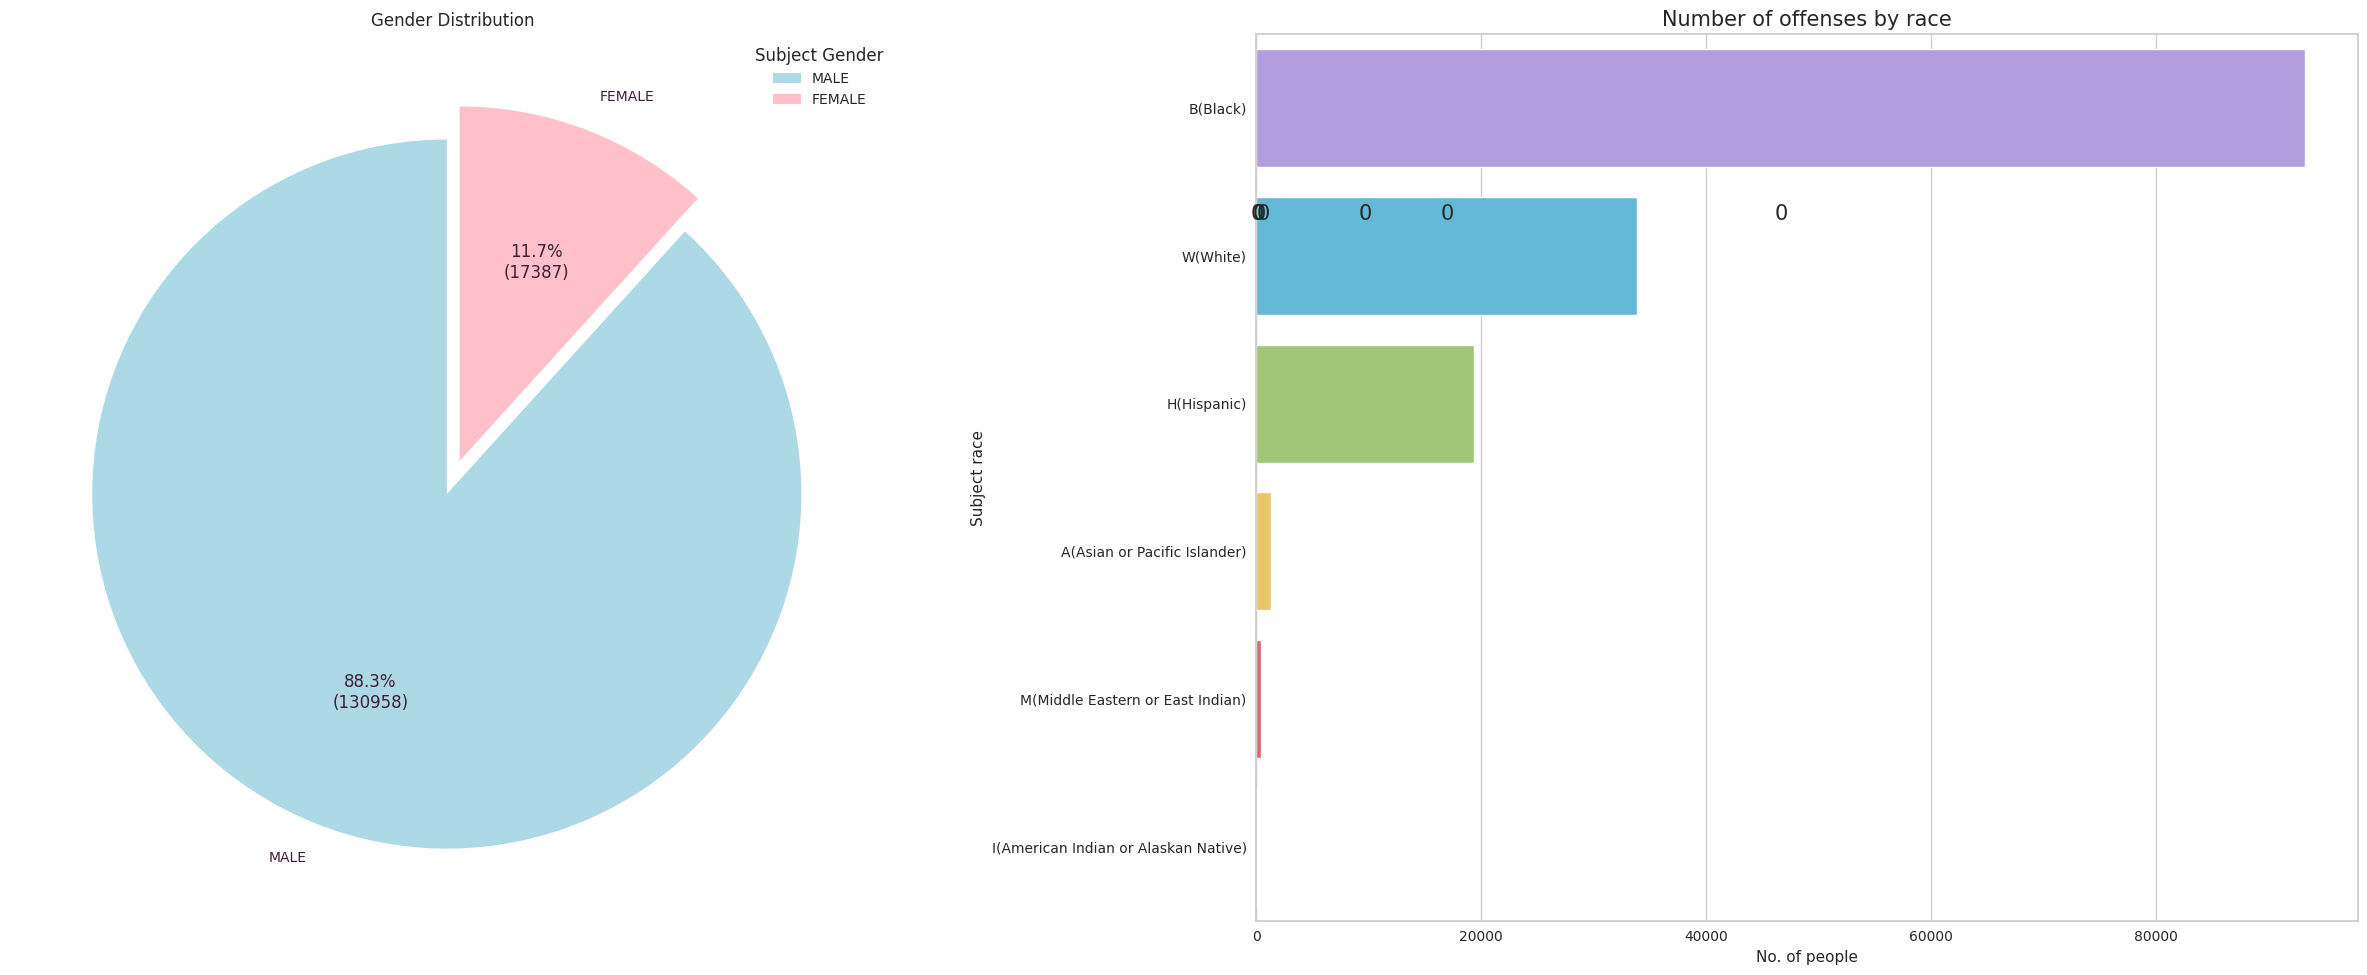

In [39]:
data = [len(df[df['SUBJECT_GENDER'] == feature]) for feature in df['SUBJECT_GENDER'].value_counts().index[0:2]]
labels = ['MALE', 'FEMALE']

colors = ['lightblue', 'pink']
explode = (0.05, 0.05)

# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100. * np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Creating the pie chart
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
plt.pie(data, labels=labels, explode=explode, colors=colors, 
        autopct=lambda pct: func(pct, data), startangle=90, textprops=dict(color="#3F1D38"))

plt.legend(labels, title="Subject Gender")
plt.title("Gender Distribution")

# Creating the bar chart
plt.subplot(1, 2, 2)
order = df['SUBJECT_RACE'].value_counts().index
colors = ['#AC92EB', '#4FC1E8', '#A0D568', '#FFCE54', '#ED5564', '#9E9FA5']

# Set the font size for titles
sns.set(font_scale=1.25)

ax = sns.countplot(data=df, y='SUBJECT_RACE', order=order, palette=colors) 

for label in ax.containers[0]:
    ax.annotate(format(int(label.get_height())), 
                (label.get_y() + label.get_width() / 2., label.get_height()), 
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')

plt.title('Number of offenses by race')
plt.ylabel('Subject race')
plt.xlabel('No. of people')

# Show plots
plt.tight_layout()
plt.show()

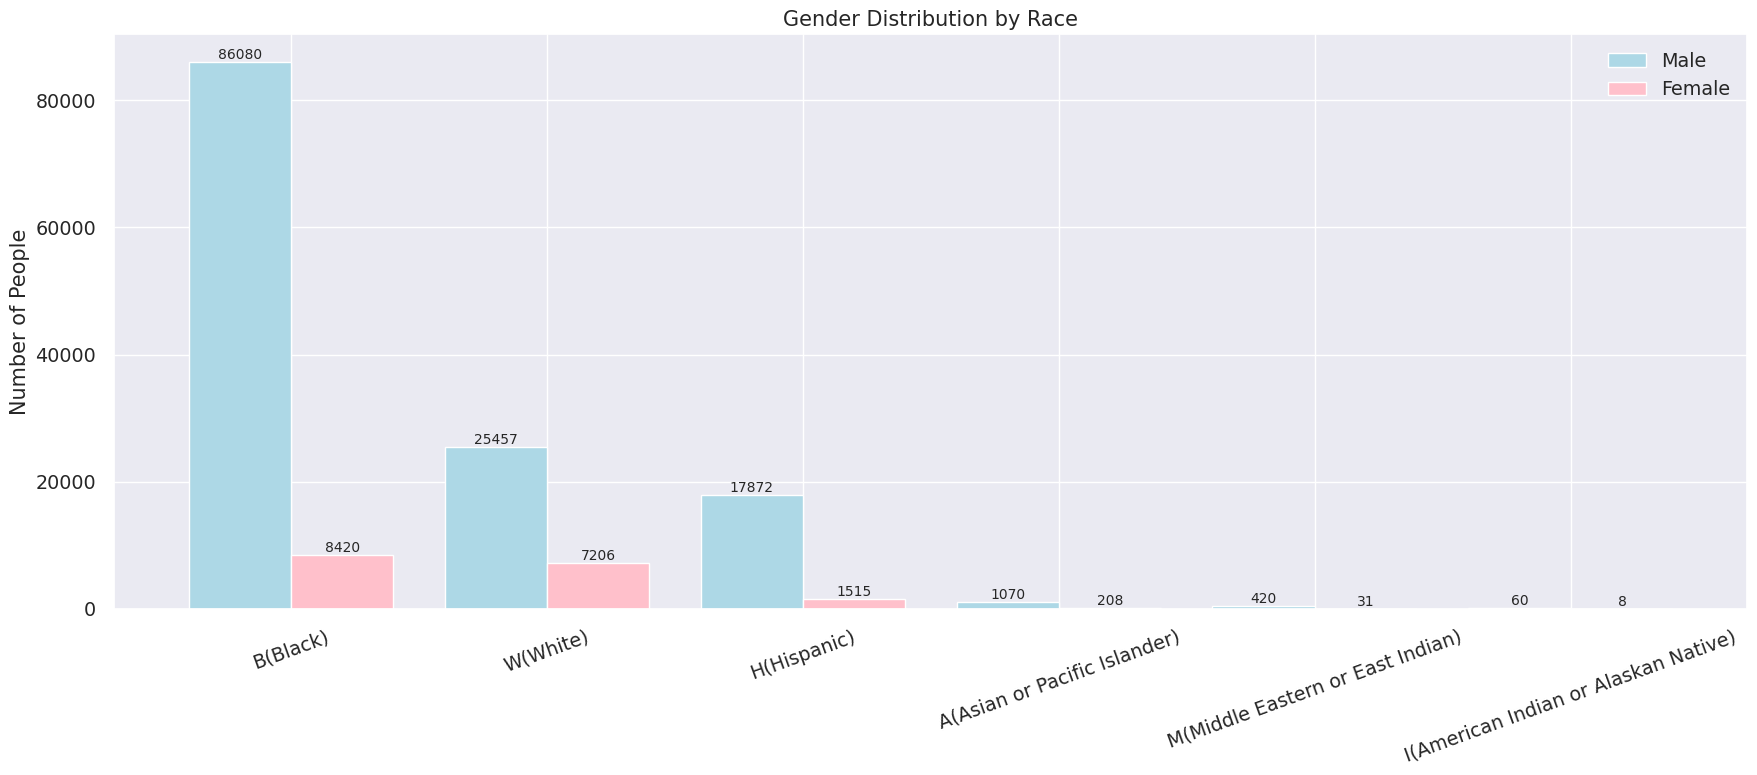

In [40]:
# Set the figure size
plt.figure(figsize=(18, 8))

# Extract the unique race categories to plot
race_to_plot = df['SUBJECT_RACE'].value_counts().keys()

# Filter data for male and female subjects
male = df[df['SUBJECT_GENDER'] == 'MALE']
female = df[df['SUBJECT_GENDER'] == 'FEMALE']

# Count the occurrences of gender and race combinations for male and female
values = [male['SUBJECT_RACE'].value_counts(), 
          female['SUBJECT_RACE'].value_counts()]

# Set up positions for the bars
x = np.arange(len(race_to_plot))
width = 0.4  # Width of the bars
colors = ['lightblue', 'pink']  # Colors for male and female bars

# Create the bar plots
plt.bar(x - width/2, values[0], width, color=colors[0], label='Male')
plt.bar(x + width/2, values[1], width, color=colors[1], label='Female')

# Annotate the bars with their values
for i in range(len(race_to_plot)):
    plt.text(x[i] - width/2, values[0][i], str(values[0][i]), ha='center', va='bottom', fontsize=10)
    plt.text(x[i] + width/2, values[1][i], str(values[1][i]), ha='center', va='bottom', fontsize=10)

# Set the x-axis labels and tick rotation
plt.xticks(x, race_to_plot, rotation=20)

# Set labels, legend, and title
plt.ylabel("Number of People")
plt.legend()
plt.title("Gender Distribution by Race")

# Display the plot
plt.tight_layout()
plt.show()

### Number of offences distrubuted by Years and Months

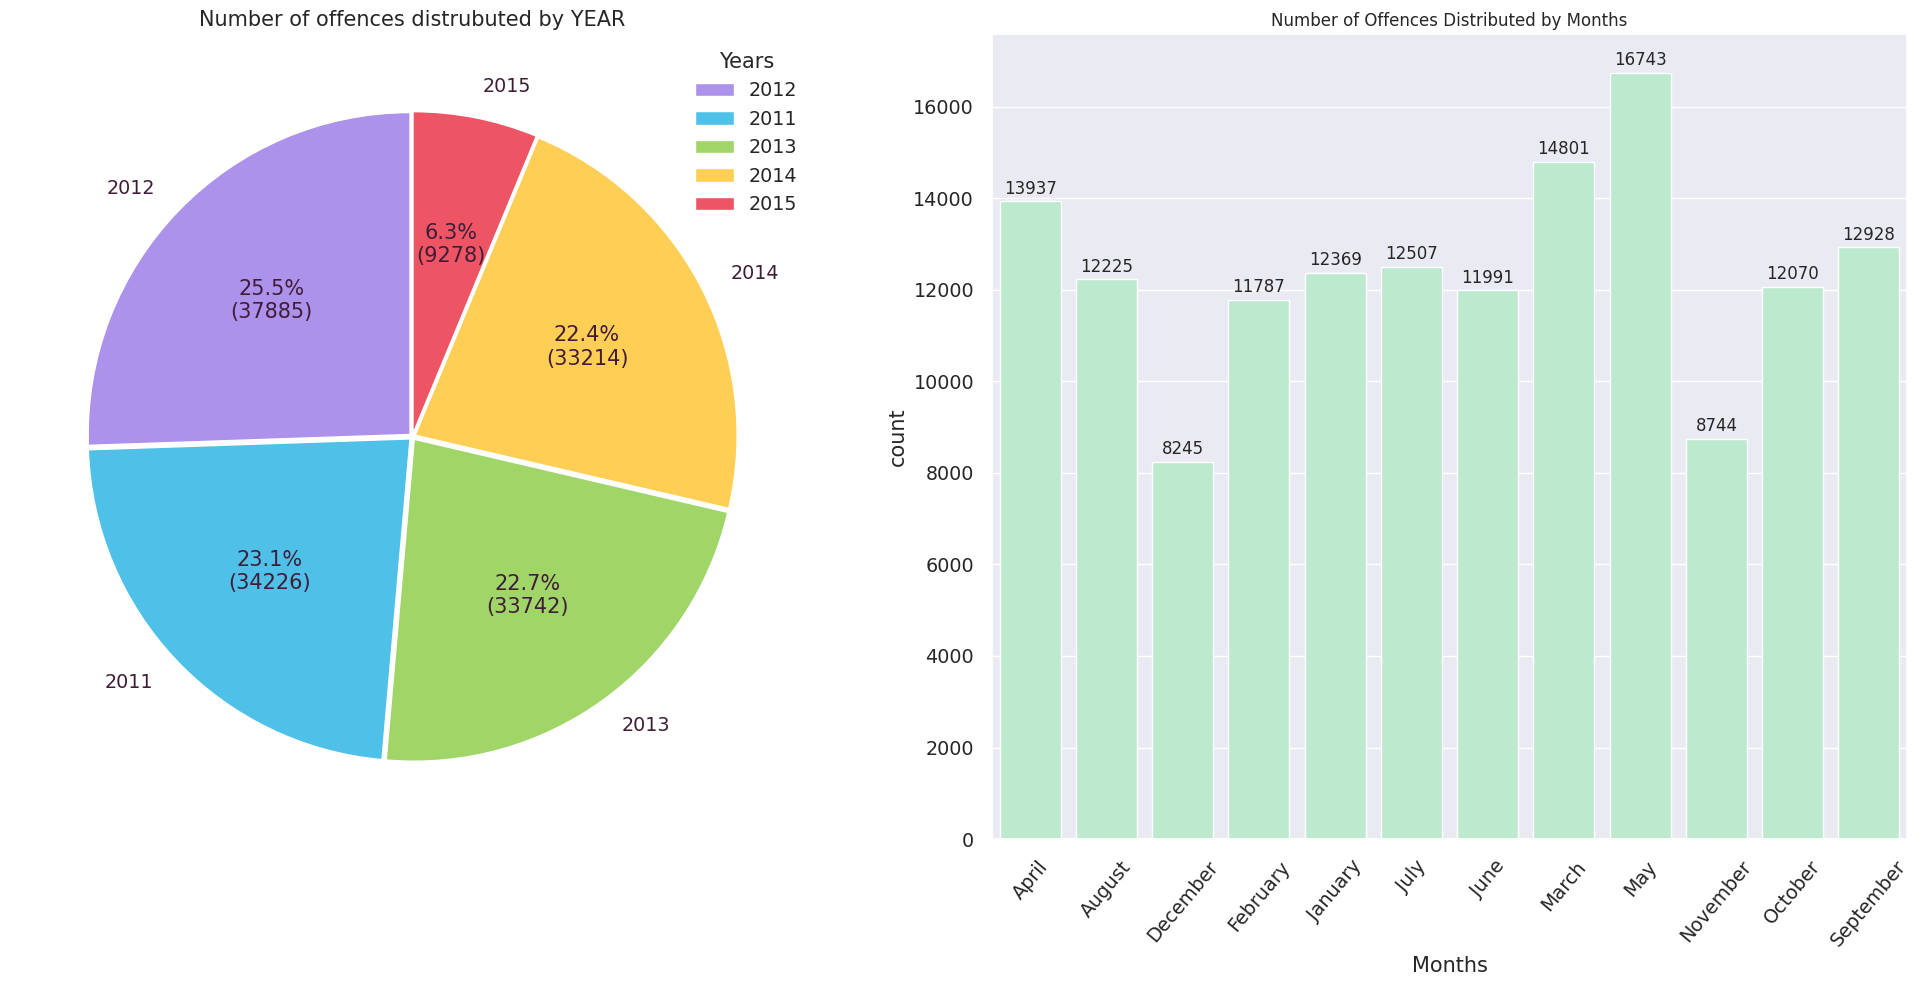

In [41]:
# Pie Chart

# Creating data
data = [len(df[df['INCIDENT_YEAR'] == feature]) for feature in df['INCIDENT_YEAR'].value_counts().index]
labels = df['INCIDENT_YEAR'].value_counts().index

colors = ['#AC92EB', '#4FC1E8', '#A0D568', '#FFCE54', '#ED5564'] # creating color parameters
explode = (0.01, 0.01, 0.01, 0.01, 0.01) # creating explode data

# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Creating plot
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.pie(data, labels=labels, explode=explode, colors=colors, autopct=lambda pct: func(pct, data), 
        startangle=90, textprops=dict(color ="#3F1D38"))

# Adding legend
plt.legend(labels, title ="Years", loc ='best',)

plt.title("Number of offences distrubuted by YEAR")

# Bat chart
plt.subplot(1, 2, 2)
order = df['INCIDENT_MONTH'].value_counts().sort_index().index

# Set the font size for titles
sns.set(font_scale=1)

ax = sns.countplot(data=df, x='INCIDENT_MONTH', order=order, color='#B5F1CC') 
plt.xticks(rotation=50)

for label in ax.containers[0]:
    ax.annotate(format(int(label.get_height())), 
                (label.get_x() + label.get_width() / 2., label.get_height()), 
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')
    
plt.title('Number of Offences Distributed by Months')
plt.xlabel('Months')

plt.tight_layout() 
plt.show()

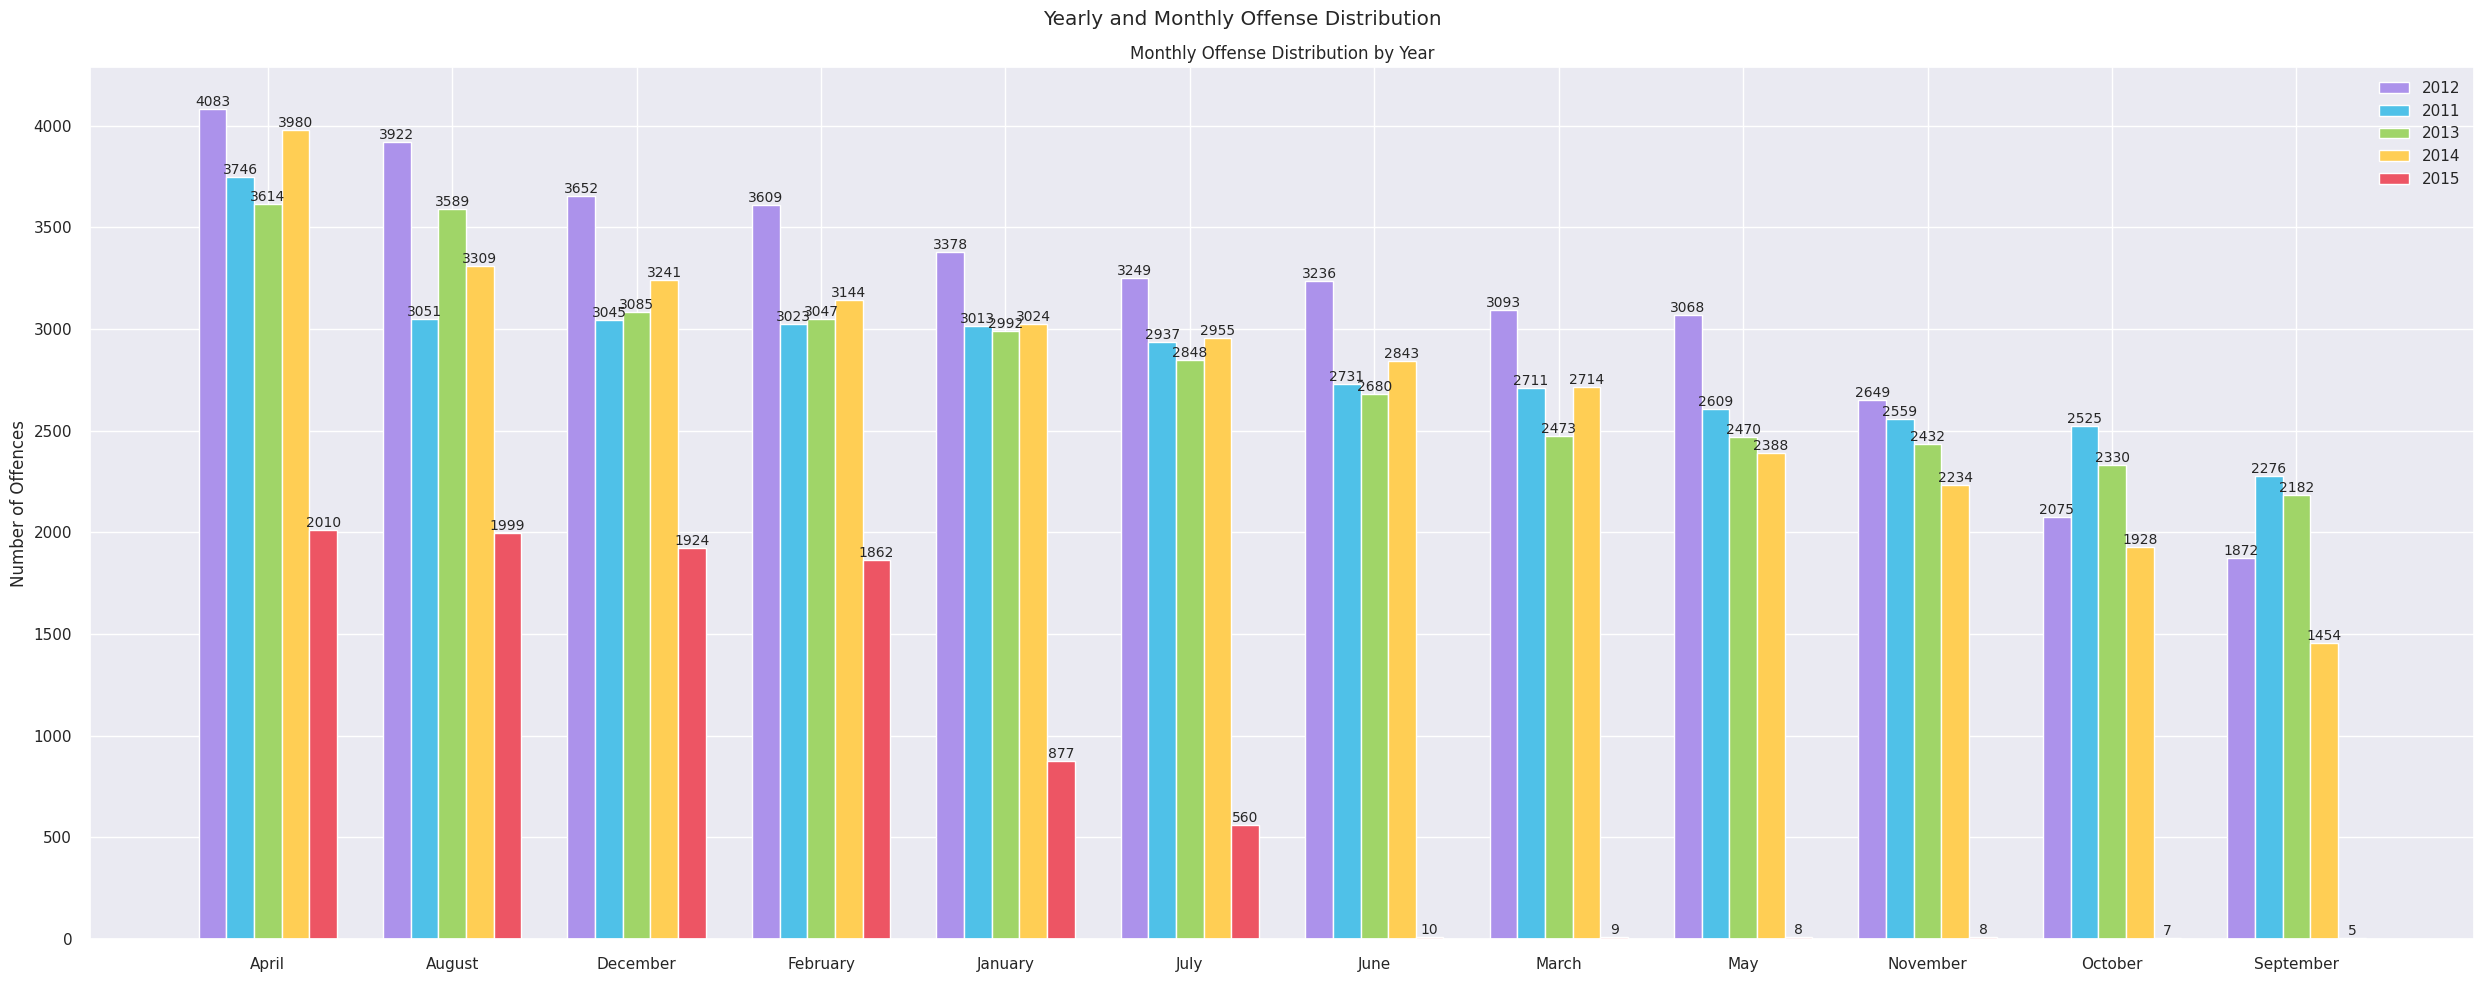

In [42]:
years_to_plot = df['INCIDENT_YEAR'].value_counts().keys()

# An empty list to store monthly counts for each year
values = []

for year in years_to_plot:
    c = df[df['INCIDENT_YEAR'] == year]
    value = c['INCIDENT_MONTH'].value_counts()
    values.append(value)

x = np.arange(1, 13)
width = 0.15
colors = ['#AC92EB', '#4FC1E8', '#A0D568', '#FFCE54', '#ED5564']

plt.figure(figsize=(25, 10))
for n in range(5):
    plt.bar(x + (n - 2) * width, values[n], width=width, color=colors[n])

# Annotate the bars with their values
for n in range(5):
    for i in range(12):
        plt.text(x[i] + (n - 2) * width, values[n][i], str(values[n][i]), ha='center', va='bottom', fontsize=10)

order = df['INCIDENT_MONTH'].value_counts().sort_index().index
plt.xticks(x, order)
plt.ylabel("Number of Offences")
plt.legend(years_to_plot)  # Use the extracted unique years
plt.title("Monthly Offense Distribution by Year")

# Adding an overall title to the entire figure
plt.suptitle("Yearly and Monthly Offense Distribution")

# Show plots
plt.tight_layout()
plt.show()

### Number of Offences Distributed by Location

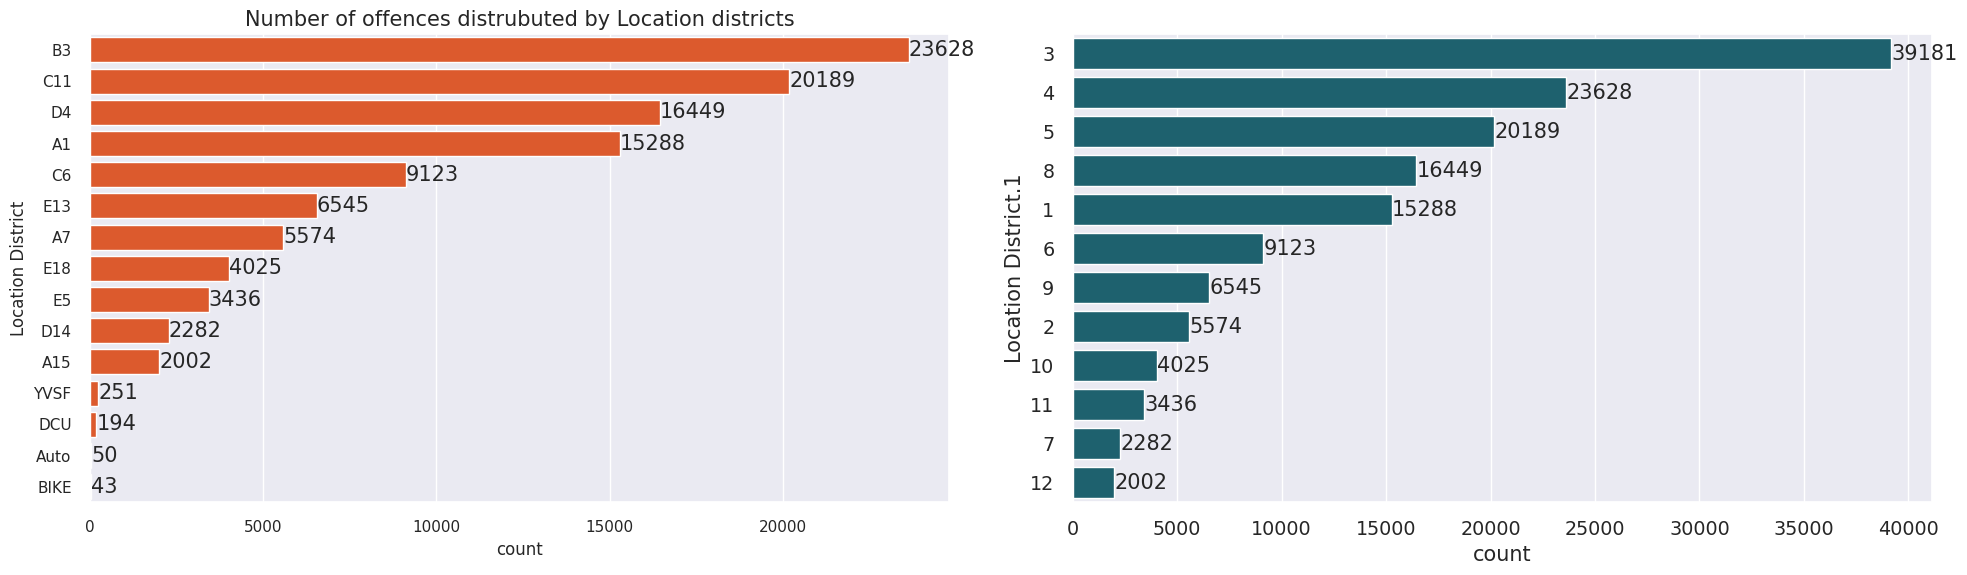

In [43]:
# Bar chart 1: Location district
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
order = df['LOCATION_DISTRICT'].value_counts().index[1:16]

# Set the font size for titles
sns.set(font_scale=1.25)

ax = sns.countplot(y=df['LOCATION_DISTRICT'], order=order, color='#F94C10')

for label in ax.containers:
    ax.bar_label(label)

plt.title('Number of offences distrubuted by Location districts')
plt.ylabel('Location District')

# Bar chart 2: Location district.1
plt.subplot(1, 2, 2)
order = df['LOCATION_DISTRICT.1'].value_counts().index[:12]
ax = sns.countplot(y=df['LOCATION_DISTRICT.1'], order=order, color='#116A7B')

for label in ax.containers:
    ax.bar_label(label)

plt.ylabel('Location District.1')

plt.tight_layout() 
plt.show()

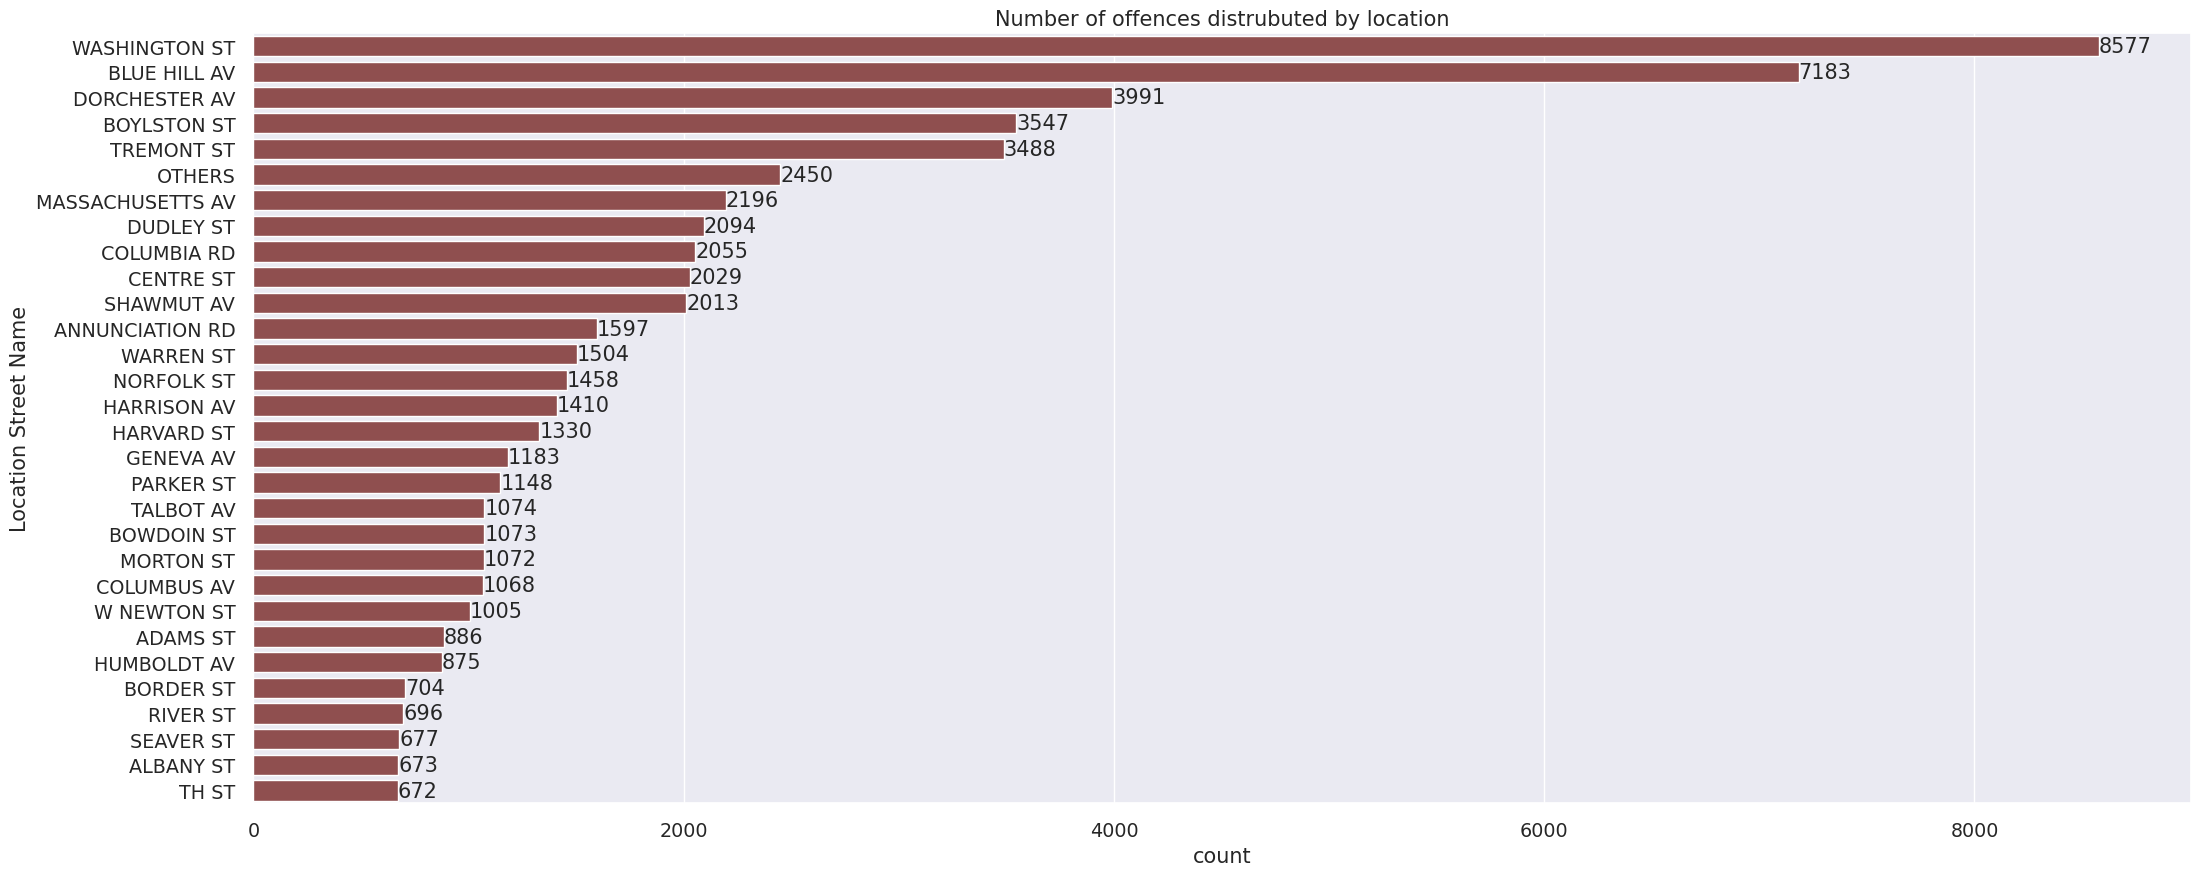

In [44]:
# Bar chart: Location
plt.figure(figsize=(25, 10))
order = df['LOCATION_STREET_ADDRESS'].value_counts().index[0:30]

# Set the font size for titles
sns.set(font_scale=1.25)

ax = sns.countplot(y=df['LOCATION_STREET_ADDRESS'], order=order, color='#9A4444')

for label in ax.containers:
    ax.bar_label(label)

plt.title('Number of offences distrubuted by location')
plt.ylabel('Location Street Name')

plt.show()

### Officer Related Information

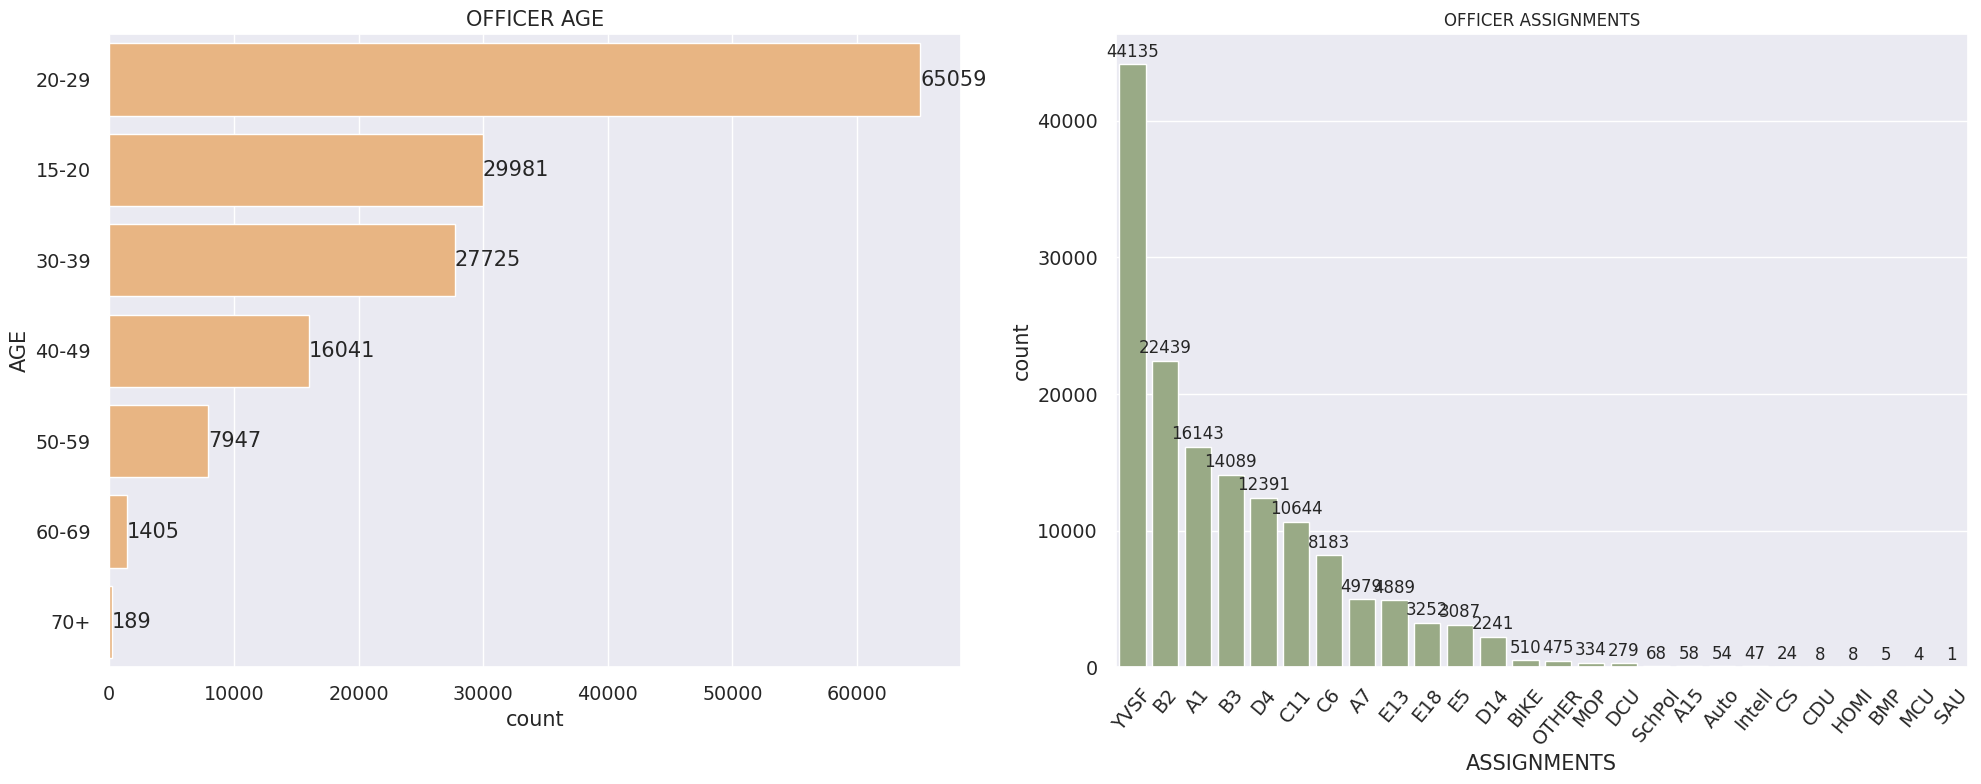

In [45]:
# Creating data
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
order = df['OFFICER_AGE'].value_counts().index[:12]
ax = sns.countplot(y=df['OFFICER_AGE'], order=order, color='#F9B572')

for label in ax.containers:
    ax.bar_label(label)

plt.ylabel('AGE')
plt.title("OFFICER AGE")

# Bat chart
plt.subplot(1, 2, 2)
order = df['OFFICER_ASSIGNMENT.1'].value_counts().index

# Set the font size for titles
sns.set(font_scale=1)

ax = sns.countplot(data=df, x='OFFICER_ASSIGNMENT.1', order=order, color='#99B080') 
plt.xticks(rotation=50)

for label in ax.containers[0]:
    ax.annotate(format(int(label.get_height())), 
                (label.get_x() + label.get_width() / 2., label.get_height()), 
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')
    
plt.title('OFFICER ASSIGNMENTS')
plt.xlabel('ASSIGNMENTS')

plt.tight_layout() 
plt.show()

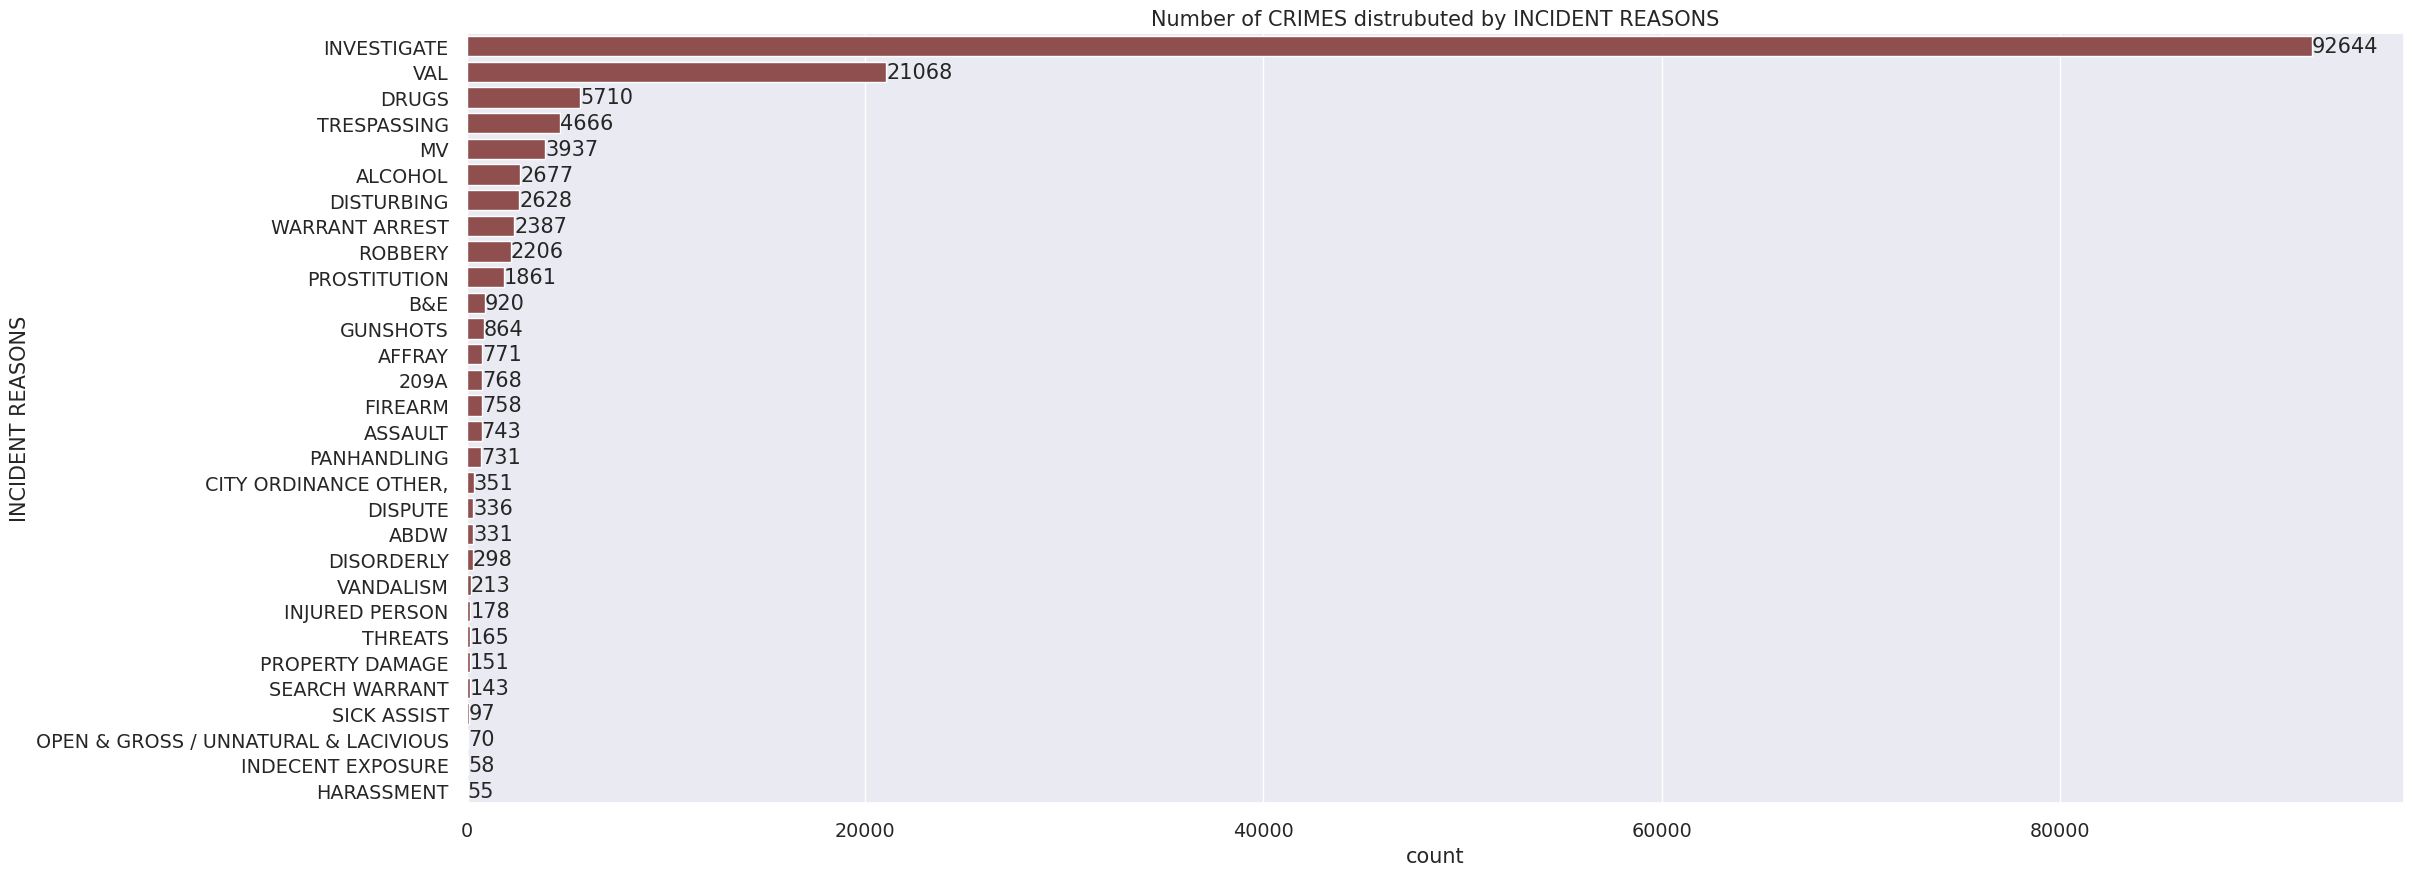

In [46]:
# Bar chart 1: Location
plt.figure(figsize=(25, 10))
order = df['INCIDENT_REASON.1'].value_counts().index[0:30]

# Set the font size for titles
sns.set(font_scale=1.25)

ax = sns.countplot(y=df['INCIDENT_REASON.1'], order=order, color='#9A4444')

for label in ax.containers:
    ax.bar_label(label)

plt.title('Number of CRIMES distrubuted by INCIDENT REASONS')
plt.ylabel('INCIDENT REASONS')

plt.show()

# Step 3: Dimensionality Reduction

In [47]:
# 88% percent
mca = MCA(n_components=2000)
mca_results = mca.fit(encoded_df)

In [48]:
mca_results.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.303,0.21%,0.21%
1,0.262,0.18%,0.38%
2,0.257,0.17%,0.56%
3,0.250,0.17%,0.73%
4,0.247,0.17%,0.90%
...,...,...,...
1995,0.059,0.04%,93.14%
1996,0.059,0.04%,93.18%
1997,0.059,0.04%,93.22%


In [49]:
features = mca_results.column_contributions_.sum(axis=1).sort_values(ascending=False)[:2000].keys()

In [50]:
selected_features = []

for feature in features:
    for i in range(len(df.columns)):
        if df.columns[i] in feature:
            selected_features.append(df.columns[i])
            
selected_features = list(set(selected_features))
selected_features

['LOCATION_STREET_ADDRESS',
 'SUBJECT_RACE',
 'OFFICER_ASSIGNMENT.1',
 'INCIDENT_REASON.1',
 'SUBJECT_DETAILS',
 'SUBJECT_DETAILS.2',
 'UNKNOWN_FIELD_TYPE']

In [51]:
reduced_df = pd.DataFrame(encoded_df[selected_features], columns=selected_features)
reduced_df.head()

,LOCATION_STREET_ADDRESS,SUBJECT_RACE,OFFICER_ASSIGNMENT.1,INCIDENT_REASON.1,SUBJECT_DETAILS,SUBJECT_DETAILS.2,UNKNOWN_FIELD_TYPE
0,1317,1,22,21,1,5,7
1,204,5,0,21,0,5,5
2,1754,1,25,35,1,2,6
3,1231,1,6,1,1,5,7
4,1645,1,4,59,1,4,5


# Step 4: Clustering

### Choosing the Number of clusters k

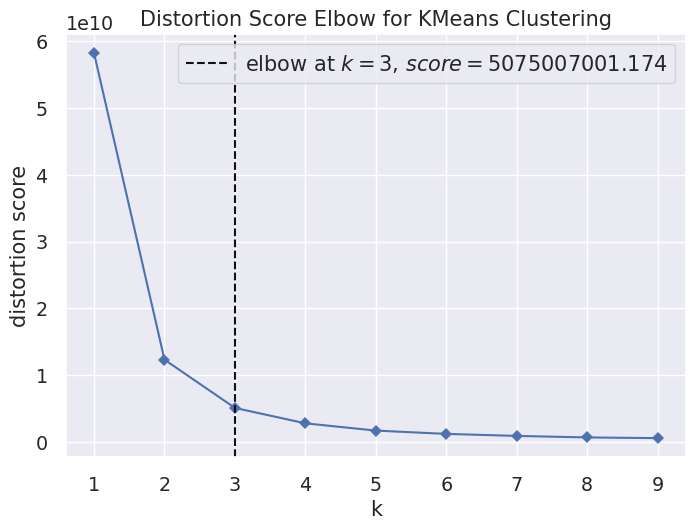

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [52]:
# create a k-Means model an Elbow-Visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 10), timings=False)
 
# fit the visualizer and show the plot
visualizer.fit(reduced_df)
visualizer.show()

### K-means clustering

In [53]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, max_iter=100).fit(reduced_df)
 
# extract centroids of clusters into a dataframe
centers = kmeans.cluster_centers_

# extract cluster labels
labels = kmeans.labels_ 

In [54]:
reduced_df['CLUSTER'] = labels
reduced_df['CLUSTER'] = reduced_df['CLUSTER'].astype(str)
reduced_df.head()

,LOCATION_STREET_ADDRESS,SUBJECT_RACE,OFFICER_ASSIGNMENT.1,INCIDENT_REASON.1,SUBJECT_DETAILS,SUBJECT_DETAILS.2,UNKNOWN_FIELD_TYPE,CLUSTER
0,1317,1,22,21,1,5,7,2
1,204,5,0,21,0,5,5,1
2,1754,1,25,35,1,2,6,0
3,1231,1,6,1,1,5,7,2
4,1645,1,4,59,1,4,5,0


# Step 5: Cluster Analysis

### Analyzing clusters characteristics

In [55]:
cluster_characteristics = []
size_of_clusters = []

for i in range(n_clusters):    
    cluster_data = encoded_df[selected_features][labels == i]
    cluster_size = len(cluster_data)    
    cluster_center = centers[i]
    avg_distance = np.mean(np.linalg.norm(cluster_data - cluster_center, axis=1))    
    cluster_characteristics.append({
        "Cluster": i,        
        "Size": cluster_size,
        "Avg Distance": avg_distance,    
    })
    
cluster_characteristics

[{'Cluster': 0, 'Size': 44246, 'Avg Distance': 127.45809500913498},
 {'Cluster': 1, 'Size': 58473, 'Avg Distance': 163.26940183317797},
 {'Cluster': 2, 'Size': 45628, 'Avg Distance': 188.8795465514593}]

In [56]:
# Calculate mean and median for each cluster
cluster_means = reduced_df.groupby('CLUSTER').mean()
cluster_medians = reduced_df.groupby('CLUSTER').median()

# Print the results
print("Cluster Means:")
print(cluster_means)

print("\nCluster Medians:")
print(cluster_medians)

Cluster Means:
         LOCATION_STREET_ADDRESS  SUBJECT_RACE  OFFICER_ASSIGNMENT.1  \
CLUSTER                                                                
0                    1758.381232      2.037653             12.177869   
1                     314.450977      2.085817             11.816035   
2                    1077.289822      2.001644             13.066845   

         INCIDENT_REASON.1  SUBJECT_DETAILS  SUBJECT_DETAILS.2  \
CLUSTER                                                          
0                37.503277         0.894928           4.111784   
1                38.064628         0.889351           4.139107   
2                37.826795         0.891865           4.128167   

         UNKNOWN_FIELD_TYPE  
CLUSTER                      
0                  6.504904  
1                  6.473552  
2                  6.510608  

Cluster Medians:
         LOCATION_STREET_ADDRESS  SUBJECT_RACE  OFFICER_ASSIGNMENT.1  \
CLUSTER                                              

In [57]:
# Print the cluster centroids
print("Cluster Centroids:")
print(centers)

Cluster Centroids:
[[1.75838123e+03 2.03765312e+00 1.21778692e+01 3.75032771e+01
  8.94928355e-01 4.11178412e+00 6.50490440e+00]
 [3.14450977e+02 2.08581739e+00 1.18160348e+01 3.80646281e+01
  8.89350640e-01 4.13910694e+00 6.47355190e+00]
 [1.07728982e+03 2.00164373e+00 1.30668449e+01 3.78267950e+01
  8.91864645e-01 4.12816692e+00 6.51060752e+00]]


### Silhouette Score, Davies-Bouldin Index, Variance Ratio Criterion, Within-Cluster Sum of Squares (WCSS)

In [58]:
silhouette_avg = silhouette_score(reduced_df, kmeans.labels_)
print('Silhouette Score', silhouette_avg)

db_index = davies_bouldin_score(reduced_df, kmeans.labels_)
print('Davies-Bouldin Index:', db_index)

ch_score = calinski_harabasz_score(reduced_df, kmeans.labels_)
print('Calinski-Harabasz Index (Variance Ratio Criterion):', ch_score)

wcss = kmeans.inertia_
print('Within-Cluster Sum of Squares (WCSS):', wcss)

Silhouette Score 0.6392318470307443
Davies-Bouldin Index: 0.4635125021108904
Calinski-Harabasz Index (Variance Ratio Criterion): 776657.9444087296
Within-Cluster Sum of Squares (WCSS): 5075007001.174372


### Cluster Visualization

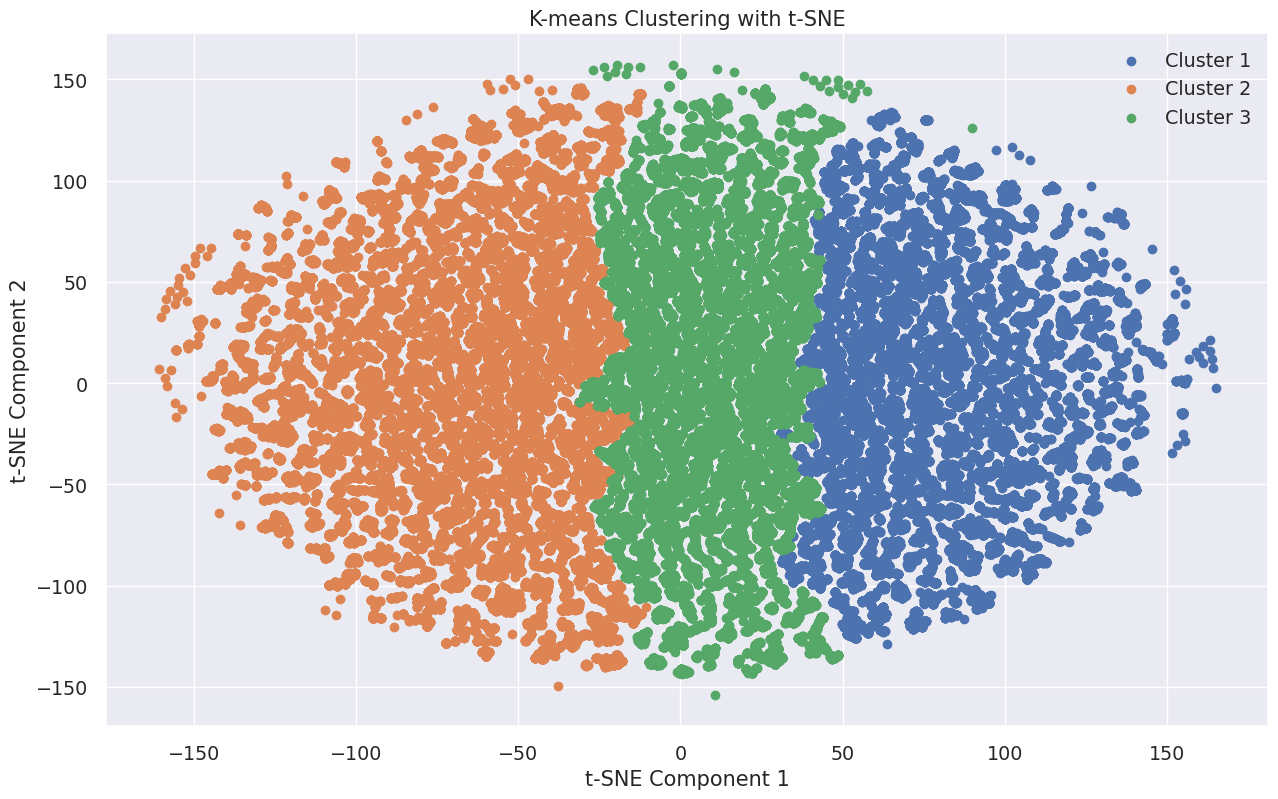

In [59]:
# Visualization of kmeans with TSNE

tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(reduced_df)

plt.figure(figsize=(15, 9))
for i in range(n_clusters):
    plt.scatter(tsne_results[labels == i][:, 0], 
                tsne_results[labels == i][:, 1], label=f'Cluster {i + 1}')
    
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('K-means Clustering with t-SNE')
plt.legend(loc ='best')
plt.show()

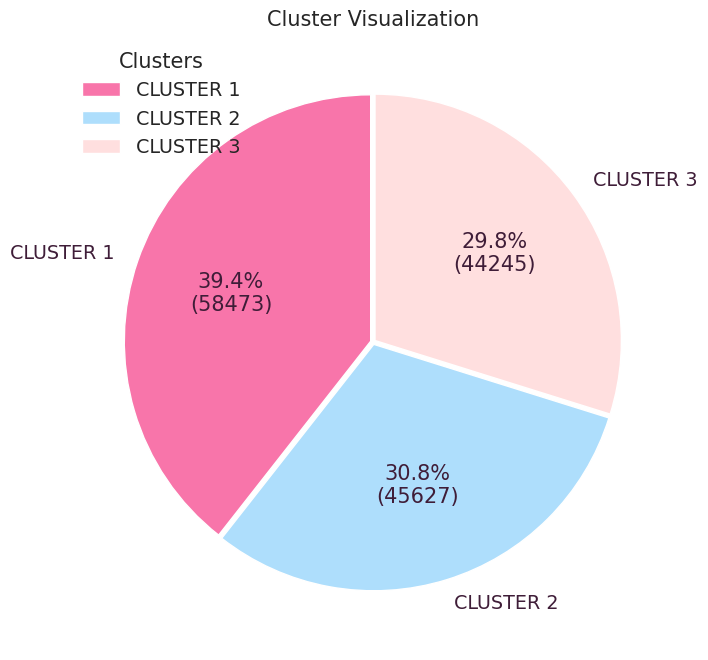

In [60]:
data = [len(reduced_df[reduced_df['CLUSTER'] == feature]) for feature in reduced_df['CLUSTER'].value_counts().index]
labels = ['CLUSTER 1', 'CLUSTER 2', 'CLUSTER 3']

colors = ['#F875AA', '#AEDEFC', '#FFDFDF']
explode = (0.01, 0.01, 0.01)

# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100. * np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Creating the pie chart
plt.figure(figsize=(20, 8))
plt.pie(data, labels=labels, explode=explode, colors=colors, 
        autopct=lambda pct: func(pct, data), startangle=90, textprops=dict(color="#3F1D38"))

plt.legend(labels, title='Clusters')
plt.title('Cluster Visualization')
plt.show()